# Toy Examples

In this notebook, we'll run Coin SVGD on some toy two-dimensional examples

First let's import some relevant packages.

In [1]:
from sgmcmcjax import ksd
import jax.numpy as jnp
from copy import deepcopy
import os

from distributions import MVN, GeneralMixtureMVN, Rosenbrock, Donut, Funnel, Squiggle
from main import CoinSVGD

from plot_utils import *
from utils import *

For saving our results later, it will be useful to set up some directories.

In [2]:
# plot directories
plot_dir = "plots/SVGD/ToyExamples"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

samples_plot_dir = plot_dir + "/" + "samples"
if not os.path.exists(samples_plot_dir):
    os.makedirs(samples_plot_dir)

ksd_v_step_plot_dir = plot_dir + "/" + "ksd_v_step"
if not os.path.exists(ksd_v_step_plot_dir):
    os.makedirs(ksd_v_step_plot_dir)

ksd_v_n_plot_dir = plot_dir + "/" + "ksd_v_n_particles"
if not os.path.exists(ksd_v_n_plot_dir):
    os.makedirs(ksd_v_n_plot_dir)

ksd_v_t_plot_dir = plot_dir + "/" + "ksd_v_t" + "/" + "adagrad"
if not os.path.exists(ksd_v_t_plot_dir):
    os.makedirs(ksd_v_t_plot_dir)

# results directories
results_dir = "results/final/SVGD/ToyExamples"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

samples_results_dir = results_dir + "/" + "samples"
if not os.path.exists(samples_results_dir):
    os.makedirs(samples_results_dir)

ksd_v_step_results_dir = results_dir + "/" + "ksd_v_step" + "/" + "adagrad"
if not os.path.exists(ksd_v_step_results_dir):
    os.makedirs(ksd_v_step_results_dir)

ksd_v_n_results_dir = results_dir + "/" + "ksd_v_n" + "/" + "adagrad"
if not os.path.exists(ksd_v_n_results_dir):
    os.makedirs(ksd_v_n_results_dir)

ksd_v_t_results_dir = results_dir + "/" + "ksd_v_t" + "/" + "adagrad"
if not os.path.exists(ksd_v_t_results_dir):
    os.makedirs(ksd_v_t_results_dir)

# for results where we re-tune the learning rate as the number of particles changes
tune_per_N = False
if tune_per_N:
    KSD_vs_n_fname_append = "_tune_per_N"
else:
    KSD_vs_n_fname_append = ""

Now we can define our models.

In [3]:
# define the various models

# gaussian
mu = np.array([-1, 1])  # mean
A = np.array([[3, -.5], [-.5, 1]])  # precision
model1 = MVN(mu, A)

# mixture of two gaussians
mu1 = np.array([-2, 2])
A1 = np.array([[2, 0], [0, 2]])
alpha1 = .5
mu2 = np.array([2, -2])
A2 = np.array([[2, 0], [0, 2]])
alpha2 = .5
means = [mu1, mu2]
precisions = [A1, A2]
weights = [1, 1]
model2 = GeneralMixtureMVN(means, precisions, weights)

# rosenbrock banana
mean = np.array([0, 1])
cov = np.array([[1, 0.5], [0.5, 1]])
a = -1
b = 1
model3 = Rosenbrock(mean, cov, a, b)

# donut
radius = 2.5
sigma2 = 0.5
model4 = Donut(radius, sigma2)

# funnel
m0 = 4  # mean of the y variable
s0 = 3  # s.d. of the y variable
m1 = 1  # mean of the x variable
model5 = Funnel(m0, m1, s0)

# squiggle
mean = np.array(1.)
cov = np.array([[2, .25], [.25, 0.5]])
freq = 2
model6 = Squiggle(mean, cov, freq)

# all models
models = [model1, model2, model3, model4, model5, model6]

For saving our results, let's define some file names.

In [4]:
# plot names
names = ["gaussian", "mixture_two_gaussians", "rosenbrock", "donut", "funnel", "squiggle"]

particle_plot_names = [name + "_particles.pdf" for name in names]
animation_names = [name + ".gif" for name in names]
KSD_step_plot_names = [name + "_KSD_vs_step.pdf" for name in names]
KSD_vs_n_plot_names = [name + "_KSD_vs_n" + KSD_vs_n_fname_append + ".pdf" for name in names]
KSD_vs_t_plot_names = [name + "_KSD_vs_t" + ".pdf" for name in names]

And for our plots, let's set up some parameters.

In [5]:
x_lims_dict = {
    model1: (-5,5),
    model2: (-5,5),
    model3: (-7,7),
    model4: (-5,5),
    model5: (-5,15),
    model6: (-5,5),
}
y_lims_dict = {
    model1: (-5,5),
    model2: (-5,5),
    model3: (-12,2),
    model4: (-5,5),
    model5: (-5,15),
    model6: (-5,5),
}

We're now ready to carry out some experiments!

### Experiment 1: Coin SVGD Samples

First we'll just take a look at some samples from Coin SVGD and SVGD.

In [6]:
# algorithm parameters
n_particles = 20
n_iter = 1000
theta0 = np.random.normal(0, .1, [n_particles, 2])

Generating samples for gaussian model.


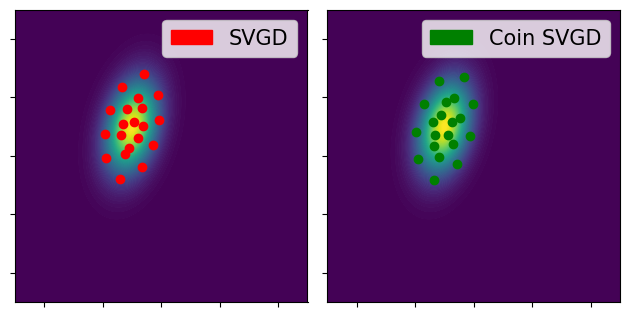

Generating samples for mixture_two_gaussians model.


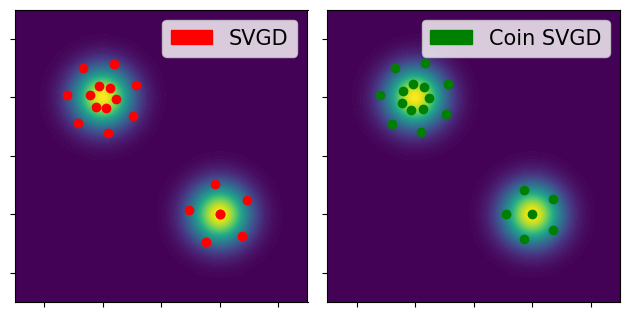

Generating samples for rosenbrock model.


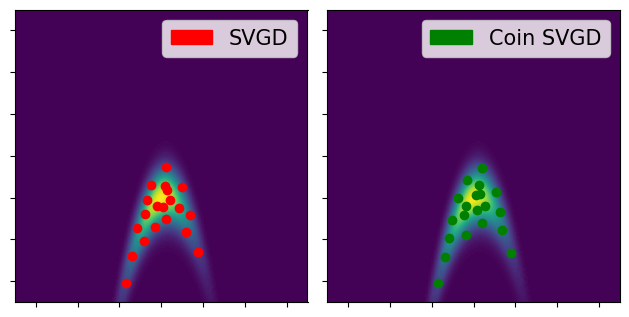

Generating samples for donut model.


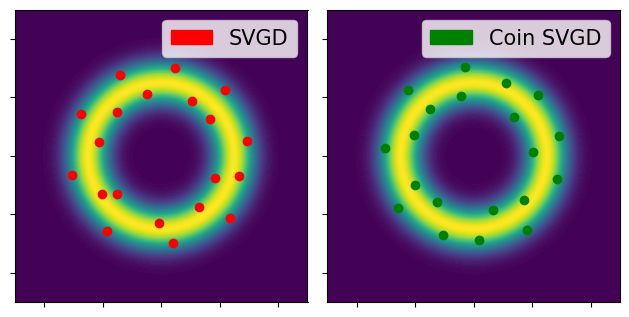

Generating samples for funnel model.


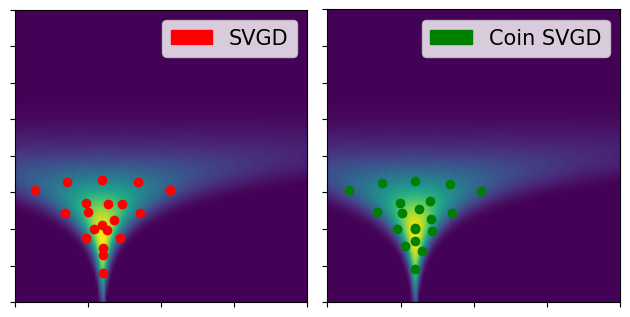

Generating samples for squiggle model.


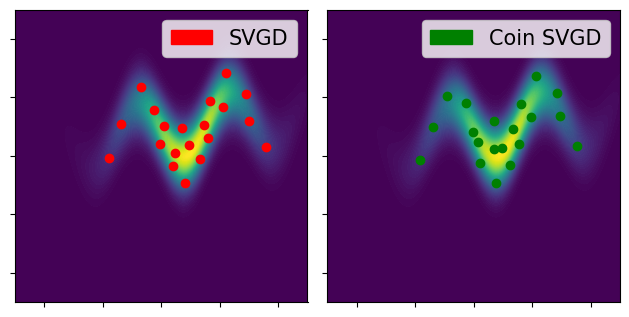

In [11]:
for i, model in enumerate(models):
    
    # print progress
    print("Generating samples for " + str(names[i]) + " model.")
    
    # run svgd and coin svgd
    svgd_theta = CoinSVGD().svgd_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter, stepsize=0.01)
    coin_svgd_theta = CoinSVGD().coin_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter)

    # save samples
    np.save(samples_results_dir + "/" + names[i] + "_svgd", svgd_theta)
    np.save(samples_results_dir + "/" + names[i] + "_coin_svgd", coin_svgd_theta)

    # plots samples
    plot_particles(svgd_theta[n_iter], coin_svgd_theta[n_iter], ln_prob=models[i].ln_prob, plot_particles=True,
                   plot_particles_density=False, same_axes=False, mesh_size=100, save=True, display=False,
                   filename=particle_plot_names[i], plot_dir=samples_plot_dir, xlim=x_lims_dict[model], 
                   ylim=x_lims_dict[model], dims=2)
    plt.show()

## Experiment 2: KSD vs Learning Rate

Now we'll take a closer look at the convergence of Coin SVGD and SVGD to the targets. Here, we plot the KSD for both methods. For SVGD, we'll vary the learning rate, and see how this changes the results. 

Computing KSD for gaussian model.
Rep: 1/2
Rep: 2/2


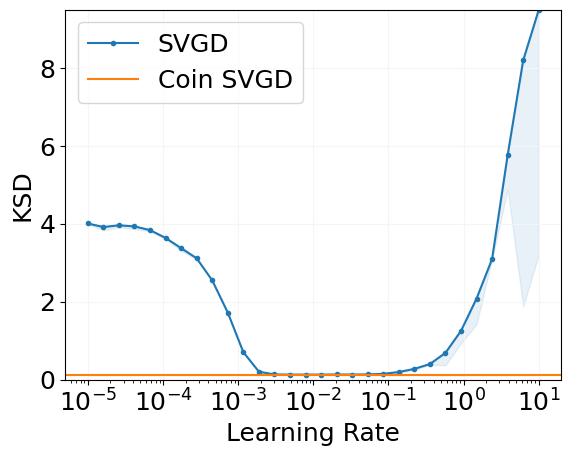

Computing KSD for mixture_two_gaussians model.
Rep: 1/2


/Users/louis/My Drive/Academia/Postdoc/Projects/Parameter-Free-SVGD/Public-Code/distributions.py:158: RuntimeWarning: invalid value encountered in divide
  return np.sum(nums, axis=0)/(np.sum(denoms, axis=0)[:, None])


Rep: 2/2


/Users/louis/My Drive/Academia/Postdoc/Projects/Parameter-Free-SVGD/Code/venv_m1/lib/python3.9/site-packages/scipy/stats/_resampling.py:92: DegenerateDataWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(DegenerateDataWarning(msg))


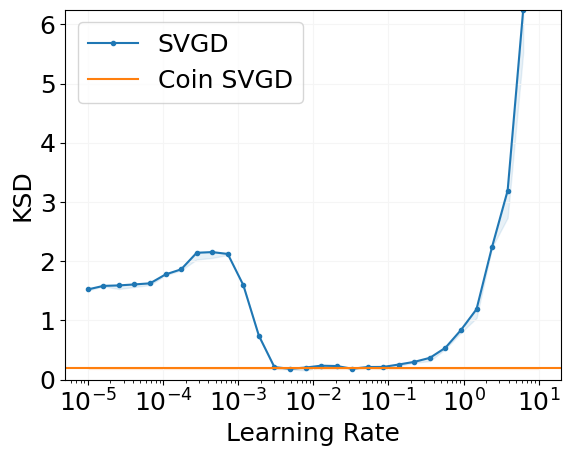

Computing KSD for rosenbrock model.
Rep: 1/2
Rep: 2/2


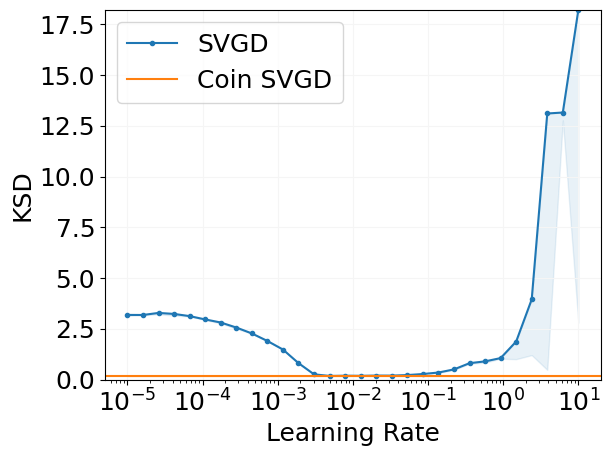

Computing KSD for donut model.
Rep: 1/2
Rep: 2/2


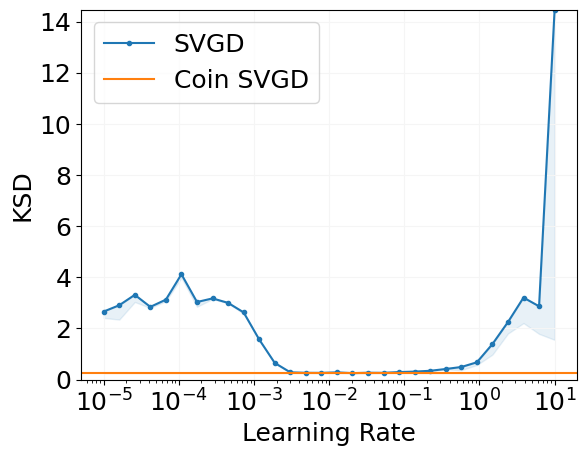

Computing KSD for funnel model.
Rep: 1/2


/Users/louis/My Drive/Academia/Postdoc/Projects/Parameter-Free-SVGD/Public-Code/distributions.py:279: RuntimeWarning: overflow encountered in power
  return ((theta - m) ** 2 - s ** 2)/(s ** 3)
/Users/louis/My Drive/Academia/Postdoc/Projects/Parameter-Free-SVGD/Public-Code/distributions.py:276: RuntimeWarning: overflow encountered in square
  return - (theta - m)/(s ** 2)
/Users/louis/My Drive/Academia/Postdoc/Projects/Parameter-Free-SVGD/Public-Code/distributions.py:279: RuntimeWarning: overflow encountered in square
  return ((theta - m) ** 2 - s ** 2)/(s ** 3)
/Users/louis/My Drive/Academia/Postdoc/Projects/Parameter-Free-SVGD/Public-Code/distributions.py:279: RuntimeWarning: invalid value encountered in divide
  return ((theta - m) ** 2 - s ** 2)/(s ** 3)


Rep: 2/2


/Users/louis/My Drive/Academia/Postdoc/Projects/Parameter-Free-SVGD/Code/venv_m1/lib/python3.9/site-packages/scipy/stats/_resampling.py:92: DegenerateDataWarning: The bootstrap distribution is degenerate; the confidence interval is not defined.
  warnings.warn(DegenerateDataWarning(msg))


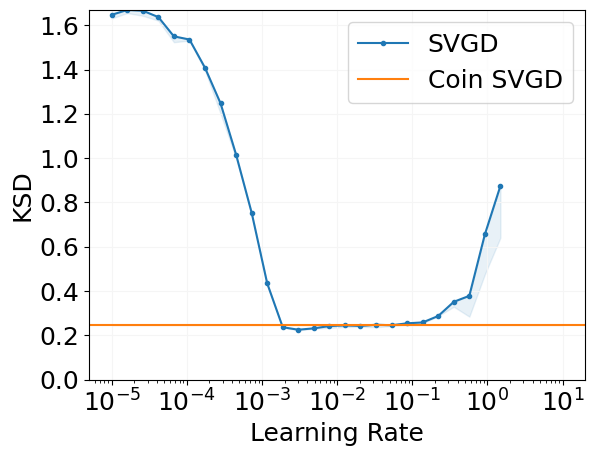

Computing KSD for squiggle model.
Rep: 1/2
Rep: 2/2


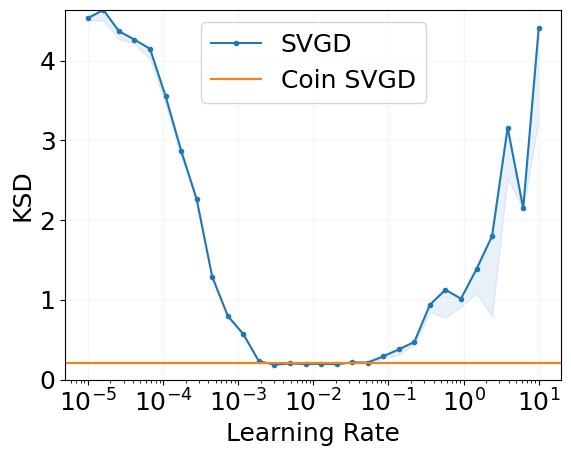

In [14]:
# experiment parameters
step = np.logspace(-5, 1, 30)
n_step = len(step)
n_reps = 2

# arrays to store ksd
svgd_ksd = np.zeros((n_reps, n_step))
coin_svgd_ksd = np.zeros((n_reps))

# array to store best LRs for SVGD
h_opt_svgd = np.zeros(len(models))
    
for i, model in enumerate(models):
    
    # print progress
    print("Computing KSD for " + str(names[i]) + " model.")

    for rep in range(n_reps):

        print("Rep: " + str(rep + 1) + "/" + str(n_reps))

        theta_tmp = np.zeros(n_step)
        theta_grad_tmp = np.zeros(n_step)
        ksd_tmp = np.zeros(n_step)

        for kk, h in enumerate(step):
            theta0 = np.random.normal(0, .1, [n_particles, 2])
            svgd_theta_tmp = CoinSVGD().svgd_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter, stepsize=h)[-1]
            svgd_theta_grad_tmp = models[i].ln_prob_grad(svgd_theta_tmp)
            svgd_ksd[rep, kk] = ksd.imq_KSD(jnp.asarray(svgd_theta_tmp), jnp.asarray(svgd_theta_grad_tmp))

        coin_theta_tmp = CoinSVGD().coin_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter)[-1]
        coin_theta_grad_tmp = models[i].ln_prob_grad(coin_theta_tmp)
        coin_svgd_ksd[rep] = ksd.imq_KSD(jnp.asarray(coin_theta_tmp), jnp.asarray(coin_theta_grad_tmp))

    # save results
    np.save(ksd_v_step_results_dir + "/" + names[i] + "_svgd", svgd_ksd)
    np.save(ksd_v_step_results_dir + "/" + names[i] + "_coin_svgd", coin_svgd_ksd)

    # compute mean and CIs
    mean_svgd_ksd = np.mean(svgd_ksd, axis=0)
    lower_svgd_ksd, upper_svgd_ksd = return_confidence_interval(svgd_ksd)
    mean_coin_svgd_ksd = np.mean(coin_svgd_ksd)
    lower_coin_svgd_ksd, upper_coin_svgd_ksd = return_confidence_interval(coin_svgd_ksd)
    
    # best learning rates for SVGD
    h_opt_svgd[i] = step[np.nanargmin(mean_svgd_ksd)]
    
    # plot results
    plt.close("all")
    plt.plot(step, mean_svgd_ksd, ".-", label="SVGD", color="C0")
    plt.fill_between(step, lower_svgd_ksd, upper_svgd_ksd, color="C0", alpha=0.1)
    plt.axhline(y=mean_coin_svgd_ksd, label="Coin SVGD", color="C1")
    plt.fill_between(step, lower_coin_svgd_ksd, upper_coin_svgd_ksd, color="C1", alpha=0.1)
    plt.grid(visible=True, color="whitesmoke", ls='-')
    plt.ylim(0,np.minimum(np.nanmax(upper_svgd_ksd), 20))
    plt.xscale("log")
    plt.legend(prop={'size':18})
    plt.xlabel("Learning Rate", fontsize=18)
    plt.ylabel("KSD", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fname = ksd_v_step_plot_dir + "/" + KSD_step_plot_names[i]
    plt.savefig(fname, format="pdf", bbox_inches="tight")
    plt.show()

## Experiment 3: KSD vs Iterations

Now let's take a look at the **convergence rate**. We'll plot the KSD vs iterations for Coin SVGD, and for SVGD with three learning rates: the optimal learning rate (as determined by our last experiment), a smaller learning rate, and a larger learning rate.

In [ ]:
# experiment parameters
n_reps = 2
ksd_vs_t_iter = np.arange(0, n_iter + 10, 10)
n_ksd_iter = len(ksd_vs_t_iter)

svgd_ksd_vs_t = np.zeros((n_reps, n_ksd_iter))
svgd_ksd_vs_t_small = np.zeros((n_reps, n_ksd_iter))
svgd_ksd_vs_t_big = np.zeros((n_reps, n_ksd_iter))
coin_svgd_ksd_vs_t = np.zeros((n_reps, n_ksd_iter))

for i, model in enumerate(models):
    
    # print progress
    print("Computing KSD vs iter. for " + str(names[i]) + " model.")

    # three learning rates for svgd
    h_best_svgd = h_opt_svgd[i]
    h_small_svgd = 2e-3 
    h_big_svgd = 2e-1  

    for rep in range(n_reps):
        
        # print progress
        print("Rep: " + str(rep + 1) + "/" + str(n_reps))
        
        # initialise
        np.random.seed(rep)
        theta0 = np.random.normal(0, 1, [n_particles, 2])

        # run coin svgd and svgd
        theta = CoinSVGD().svgd_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter, stepsize=h_best_svgd)
        theta_small = CoinSVGD().svgd_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter, stepsize=h_small_svgd)
        theta_big = CoinSVGD().svgd_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter, stepsize=h_big_svgd)
        coin_theta = CoinSVGD().coin_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter)
        
        # compute ksd
        for tt, t in enumerate(ksd_vs_t_iter):
            grads = models[i].ln_prob_grad(theta[t])
            grads_small = models[i].ln_prob_grad(theta_small[t])
            grads_big = models[i].ln_prob_grad(theta_big[t])
            coin_grads = models[i].ln_prob_grad(coin_theta[t])
            svgd_ksd_vs_t[rep, tt] = ksd.imq_KSD(jnp.asarray(theta[t]), jnp.asarray(grads))
            svgd_ksd_vs_t_small[rep, tt] = ksd.imq_KSD(jnp.asarray(theta_small[t]), jnp.asarray(grads_small))
            svgd_ksd_vs_t_big[rep, tt] = ksd.imq_KSD(jnp.asarray(theta_big[t]), jnp.asarray(grads_big))
            coin_svgd_ksd_vs_t[rep, tt] = ksd.imq_KSD(jnp.asarray(coin_theta[t]), jnp.asarray(coin_grads))

    np.save(ksd_v_t_results_dir + "/" + names[i] + "_svgd", svgd_ksd_vs_t)
    np.save(ksd_v_t_results_dir + "/" + names[i] + "_svgd_small", svgd_ksd_vs_t_small)
    np.save(ksd_v_t_results_dir + "/" + names[i] + "_svgd_big", svgd_ksd_vs_t_big)
    np.save(ksd_v_t_results_dir + "/" + names[i] + "_coin", coin_svgd_ksd_vs_t)

    # compute mean and CIs
    svgd_ksd_vs_t_mean = np.mean(svgd_ksd_vs_t, axis=0)
    svgd_ksd_vs_t_lower, svgd_ksd_vs_t_upper = return_confidence_interval(svgd_ksd_vs_t)
    svgd_ksd_vs_t_mean_small = np.mean(svgd_ksd_vs_t_small, axis=0)
    svgd_ksd_vs_t_lower_small, svgd_ksd_vs_t_upper_small = return_confidence_interval(svgd_ksd_vs_t_small)
    svgd_ksd_vs_t_mean_big = np.mean(svgd_ksd_vs_t_big, axis=0)
    svgd_ksd_vs_t_lower_big, svgd_ksd_vs_t_upper_big = return_confidence_interval(svgd_ksd_vs_t_big)
    coin_svgd_ksd_vs_t_mean = np.mean(coin_svgd_ksd_vs_t, axis=0)
    coin_svgd_ksd_vs_t_lower, coin_svgd_ksd_vs_t_upper = return_confidence_interval(coin_svgd_ksd_vs_t)

    # plot results
    plt.plot(ksd_vs_t_iter, svgd_ksd_vs_t_mean, color="C0", label="SVGD (Optimal LR)")
    plt.fill_between(ksd_vs_t_iter, svgd_ksd_vs_t_lower, svgd_ksd_vs_t_upper, color="C0", alpha=0.1)
    plt.plot(ksd_vs_t_iter, svgd_ksd_vs_t_mean_small, color="C2", label="SVGD (Small LR)")
    plt.fill_between(ksd_vs_t_iter, svgd_ksd_vs_t_lower_small, svgd_ksd_vs_t_upper_small, color="C2", alpha=0.1)
    plt.plot(ksd_vs_t_iter, svgd_ksd_vs_t_mean_big, color="C3", label="SVGD (Large LR)")
    plt.fill_between(ksd_vs_t_iter, svgd_ksd_vs_t_lower_big, svgd_ksd_vs_t_upper_big, color="C3", alpha=0.1)
    plt.plot(ksd_vs_t_iter, coin_svgd_ksd_vs_t_mean, color="C1", label="Coin SVGD")
    plt.fill_between(ksd_vs_t_iter, coin_svgd_ksd_vs_t_lower, coin_svgd_ksd_vs_t_upper, color="C1", alpha=0.1)
    plt.grid(visible=True, color="whitesmoke", ls='-')
    plt.legend(prop={'size': 15})
    plt.xlabel("Iterations", fontsize=18)
    plt.ylabel("KSD", fontsize=18)
    plt.legend(prop={'size': 15})
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
    fname = ksd_v_t_plot_dir + "/" + KSD_vs_t_plot_names[i]
    plt.savefig(fname, format="pdf", bbox_inches="tight")
    plt.show()

## Experiment 4: KSD vs Number of Particles (N)

Computing KSD vs N for gaussian model.
Rep: 1/2
Rep: 2/2


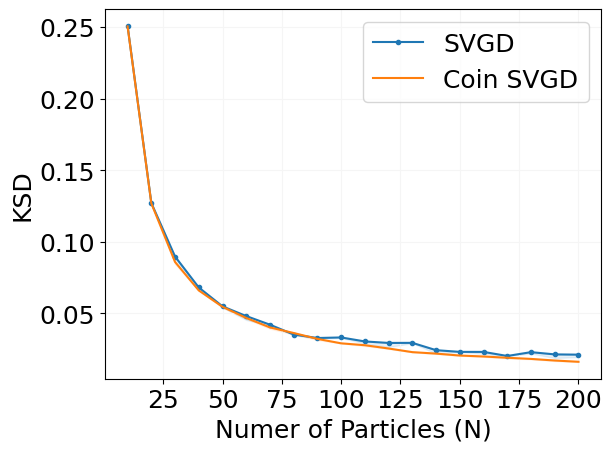

Computing KSD vs N for mixture_two_gaussians model.
Rep: 1/2
Rep: 2/2


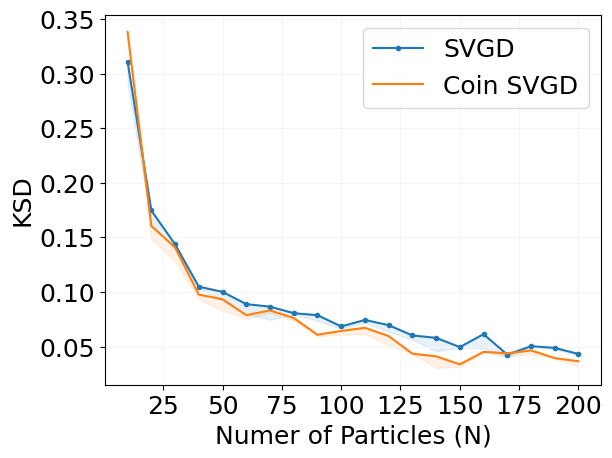

Computing KSD vs N for rosenbrock model.
Rep: 1/2
Rep: 2/2


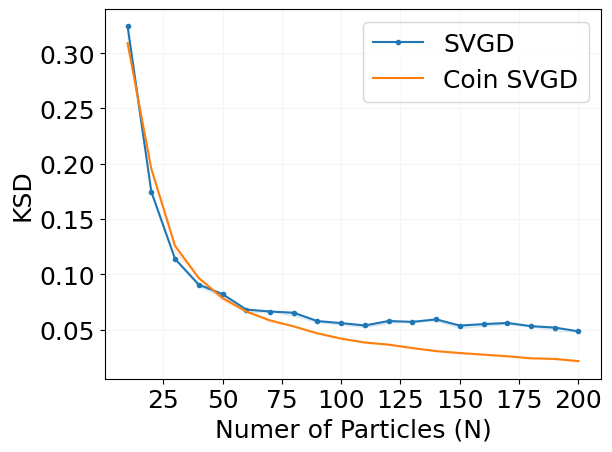

Computing KSD vs N for donut model.
Rep: 1/2
Rep: 2/2


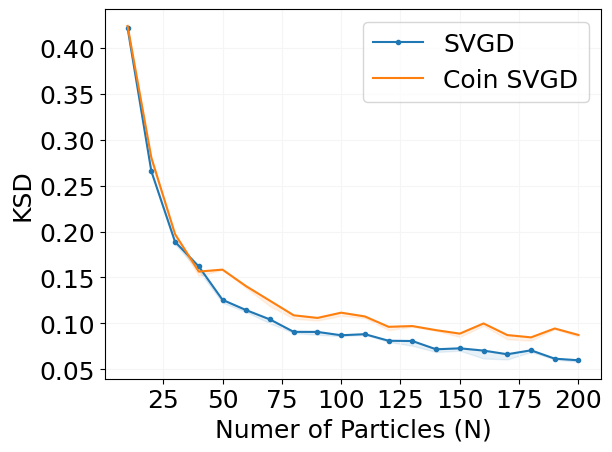

Computing KSD vs N for funnel model.
Rep: 1/2
Rep: 2/2


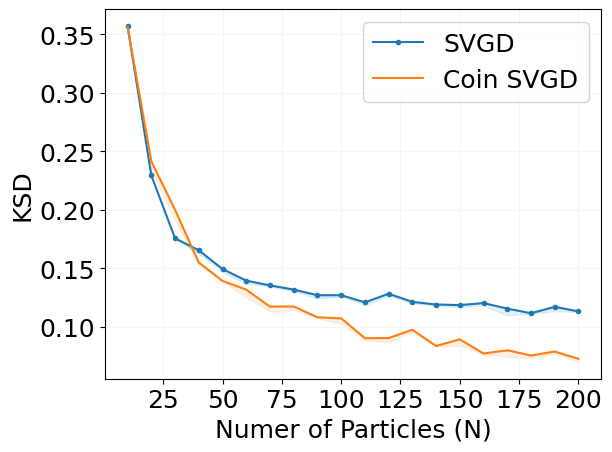

Computing KSD vs N for squiggle model.
Rep: 1/2
Rep: 2/2


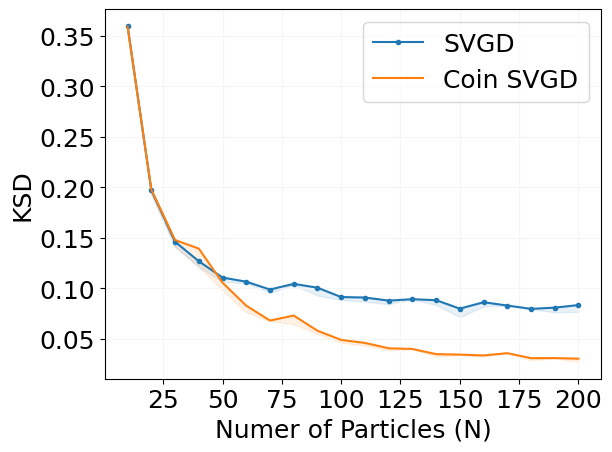

In [20]:
# experiment parameters
N_vals = np.linspace(10, 200, 20)
n_reps = 2

# arrays to store ksd vs n
svgd_ksd_vs_n = np.zeros((n_reps, len(N_vals)))
coin_svgd_ksd_vs_n = np.zeros((n_reps, len(N_vals)))

for i, model in enumerate(models):

    # print progress
    print("Computing KSD vs N for " + str(names[i]) + " model.")

    for rep in range(n_reps):
        
        # print progress
        print("Rep: " + str(rep+1) + "/" + str(n_reps))

        for nn, N in enumerate(N_vals):

            theta0 = np.random.normal(0, .1, [int(N), 2])

            # tune learning rate
            if tune_per_N:
                if rep == 0:  # only tune on first repeat otherwise very expensive
                    svgd_ksd_tmp = np.zeros(n_step)
                    for kk, h in enumerate(step):
                        theta = CoinSVGD().svgd_update(theta0.copy(), models[i].ln_prob_grad, n_iter=1000, stepsize=h)[-1]
                        theta_grad = models[i].ln_prob_grad(theta)
                        svgd_ksd_tmp[kk] = ksd.imq_KSD(jnp.asarray(theta), jnp.asarray(theta_grad))
                    h_best_svgd = step[np.nanargmin(svgd_ksd_tmp)]
            else:
                h_best_svgd = h_opt_svgd[i]
            svgd_theta = CoinSVGD().svgd_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter, stepsize=h_best_svgd)[-1]
            svgd_theta_grad = models[i].ln_prob_grad(svgd_theta)
            svgd_ksd_vs_n[rep, nn] = ksd.imq_KSD(jnp.asarray(svgd_theta), jnp.asarray(svgd_theta_grad))

            coin_svgd_theta = CoinSVGD().coin_update(theta0.copy(), models[i].ln_prob_grad, n_iter=n_iter)[-1]
            coin_svgd_theta_grad = models[i].ln_prob_grad(coin_svgd_theta)
            coin_svgd_ksd_vs_n[rep, nn] = ksd.imq_KSD(jnp.asarray(coin_svgd_theta), jnp.asarray(coin_svgd_theta_grad))

    # save results
    np.save(ksd_v_n_results_dir + "/" + names[i] + "_svgd" + KSD_vs_n_fname_append, svgd_ksd_vs_n)
    np.save(ksd_v_n_results_dir + "/" + names[i] + "_coin_svgd" + KSD_vs_n_fname_append, coin_svgd_ksd_vs_n)

    # compute mean and CIs
    svgd_mean = svgd_ksd_vs_n.mean(0)
    svgd_lower, svgd_upper = return_confidence_interval(svgd_ksd_vs_n)
    coin_svgd_mean = coin_svgd_ksd_vs_n.mean(0)
    coin_svgd_lower, coin_svgd_upper = return_confidence_interval(coin_svgd_ksd_vs_n)

    # plot results
    plt.close("all")
    plt.plot(N_vals, svgd_mean, ".-", label="SVGD", color="C0")
    plt.fill_between(N_vals, svgd_lower, svgd_upper, color="C0", alpha=0.1)
    plt.plot(N_vals, coin_svgd_mean, label="Coin SVGD", color="C1")
    plt.fill_between(N_vals, coin_svgd_lower, coin_svgd_upper, color="C1", alpha=0.1)
    plt.grid(visible=True, color="whitesmoke", ls='-')
    # plt.xscale("log")
    plt.legend(prop={'size':18})
    plt.xlabel("Numer of Particles (N)", fontsize=18)
    plt.ylabel("KSD", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fname = ksd_v_n_plot_dir + "/" + "both_plot_" + KSD_vs_n_plot_names[i]
    plt.savefig(fname, format="pdf", bbox_inches="tight")
    plt.show()